In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import io, color
from skimage.transform import resize
from skimage.feature import hog
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

from PIL import Image
%matplotlib inline

# Get the directory path
train_directory_path = "/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/train_ims"
test_directory_path = "/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/test_ims"

# List filenames in alphabetical order
train_filenames = sorted(os.listdir(train_directory_path))
test_filenames  = sorted(os.listdir(test_directory_path))

In [3]:
train_df = pd.read_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/train.csv") #change path
test_df = pd.read_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/test.csv") #change path

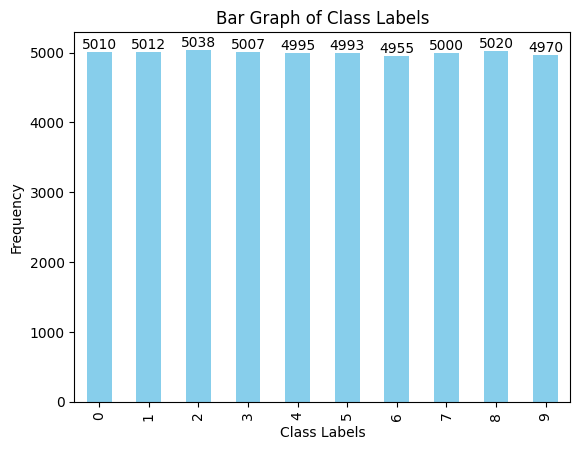

In [4]:
import matplotlib.pyplot as plt

all_labels = pd.Series(range(10))  # Creates a series from 0 to 9

# Count the occurrences of each class label and reindex with all possible labels
class_counts = train_df['label'].value_counts().reindex(all_labels, fill_value=0)

# Plotting
ax = class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Bar Graph of Class Labels')


# Adding text labels on each bar
for p in ax.patches:
    # Only annotate non-zero bars
    if p.get_height() > 0:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5),  # Reduced y offset to bring text lower
                    textcoords='offset points')

plt.show()


In [30]:
print(train_df.describe())

              label
count  50000.000000
mean       4.493480
std        2.872776
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max        9.000000


In [5]:
aug = iaa.Sequential([
    iaa.Fliplr(0.5),  # Flip horizontally with 50% probability
    iaa.Flipud(0.5),  # Flip vertically with 50% probability
    iaa.Affine(rotate=(-10, 10)),  # Randomly rotate the image by up to 10 degrees
    iaa.GaussianBlur(sigma=(0.0, 0.2)),  # Apply Gaussian blur with a sigma between 0 and 0.5
])

In [6]:
x_train = []
x_test = []


train_df = pd.read_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/train.csv") #change path
test_df = pd.read_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/test.csv") #change path


for i in range(50000): #only checking first 1000 images
    image = io.imread(f"{train_directory_path}/{train_filenames[i]}")
    x_train.append(image)

    '''if i < 40000:
        x_train.append(image)
    else:
        x_test.append(image)


        '''

ratio_a= 10000
ratio_b= 20000
    
augmented_images = aug(images=x_train[ratio_a:ratio_b])

x_train = np.array(x_train)
x_train = np.concatenate((x_train, augmented_images))


y_train = np.array(train_df["label"].to_numpy())
y_train = np.concatenate((y_train, y_train[ratio_a:ratio_b]))

y_test = np.array(test_df["label"].to_numpy())

assert x_train.shape == (50000+(ratio_b-ratio_a), 32, 32, 3)


y_train = y_train.reshape(-1)

assert y_train.shape == (50000+(ratio_b-ratio_a),)


In [9]:
def get_sift_feature(im):
    gray_im = color.rgb2gray(im)
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute((gray_im * 255).astype("uint8"), None)
    if descriptors is None:
        return np.zeros((128,))
    return np.mean(descriptors, axis=0) 

def get_hog_feature(im):
    gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) / 255
    hog_features = hog(gray_im, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

    hsv_image = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    
    hist_features = []
    for channel in cv2.split(hsv_image):
        hist_features.append(cv2.calcHist([channel], [0], None, [8], [0, 256]))

    hist_features = np.concatenate(hist_features).flatten() / (image.shape[0] * image.shape[1])

    merged_features = np.concatenate((hog_features, hist_features))
    return(merged_features)


def sift_hog_combined_features(im):
    hog_features = get_hog_feature(im)
    sift_features = get_sift_feature(im)
    combined_features = np.concatenate((hog_features, sift_features))
    return combined_features

In [10]:
sift_hog_features_train = []

for image1 in x_train:
    sift_hog_features_train.append(sift_hog_combined_features(image1)) #checking for sift feature 

sift_hog_features_train = np.array(sift_hog_features_train)

In [35]:
print(sift_hog_features_train.shape)

(60000, 476)


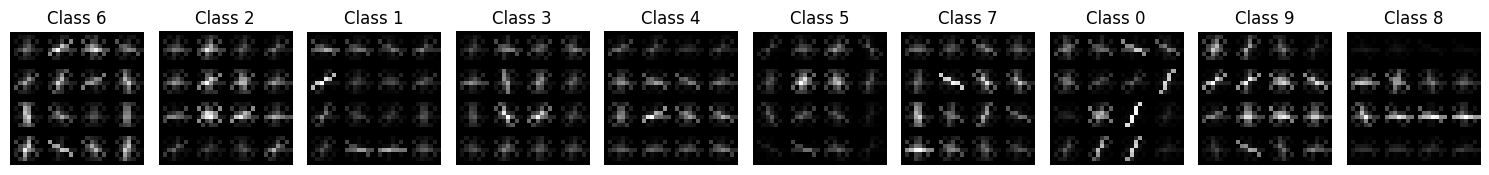

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog

def get_hog_feature(im, visualize=False):
    gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) / 255
    if visualize:
        hog_features, hog_image = hog(gray_im, orientations=9, pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2), visualize=True, feature_vector=True)
    else:
        hog_features = hog(gray_im, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=False, feature_vector=True)
    return hog_features, hog_image if visualize else hog_features

# Initialize an empty dictionary to store the first image of each class
first_images = {}

# Loop through the dataset
for img, label in zip(x_train, y_train):
    if label not in first_images:
        first_images[label] = img
    # Optionally: break if all classes are found
    if len(first_images) == 10:  # replace 'number_of_classes' with the actual number
        break

# Visualize HOG for the first image of each class
fig, axes = plt.subplots(1, len(first_images), figsize=(15, 3))
for ax, (label, image) in zip(axes, first_images.items()):
    _, hog_image = get_hog_feature(image, visualize=True)
    ax.imshow(hog_image, cmap='gray')
    ax.set_title(f'Class {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()